## Aula 7 - Segmentação por Cor

Iremos aplicar as técnicas de limiarização e segmentação vistas em aula. O OpenCV tem todos os métodos já implementados.

Vamos importar as bibliotecas necessárias:

In [7]:
%matplotlib inline
import cv2 # OpenCV
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
from scipy import ndimage

!wget https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/lenna.jpg # Download da nossa imagem base
!wget https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/nemo.jpeg # Download da nossa imagem base

--2021-06-02 18:25:56--  https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/lenna.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/jpeg]
Saving to: ‘lenna.jpg.4’

lenna.jpg.4         100%[===================>] 462.73K  --.-KB/s    in 0.04s   

2021-06-02 18:25:57 (12.4 MB/s) - ‘lenna.jpg.4’ saved [473831/473831]

--2021-06-02 18:25:57--  https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/nemo.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12078 (12K) [image/jpeg]
Saving to:

E agora, vamos carregar a imagem da Lenna:

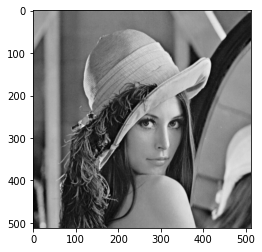

In [8]:
img = cv2.imread('lenna.jpg',0)
plt.imshow(img, cmap='gray')

### 7.1 Limiarização simples

É o método mais simples de limiarização, onde a segmentação acontece através de um limiar. Todos os tipos vistos em sala são facilmente implementados no OpenCV, precisando apenas mudar um argumento do método chamado.

Os tipos são:
1. [BINARY](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a147222a96556ebc1d948b372bcd7ac59)
2. [BINARY_INV](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a19120b1a11d8067576cc24f4d2f03754)
3. [TRUNC](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576ac7e89a5e95490116e7d2082b3096b2b8)
4. [THRESH_TOZERO](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a0e50a338a4b711a8c48f06a6b105dd98)
5. [THRESH_TOZERO_INV](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a47518a30aae90d799035bdcf0bb39a50)

É importante sempre ler a documentação para entender o que está acontecendo. 

Para realizar uma limiarização simples utilizaremos o método [threshold()](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57).

* O primeiro argumento do método é a imagem que queremos segmentar. 
* O valor de limiar é definido como o segundo argumento. 
* O próximo argumento é o valor máximo que é usado em  dos tipos. Definiremos 127 como threshold e 255 como o máximo. Para mais detalhes, ler a documentação do método.

Vamos aplicar cada um desses tipos de segmentação na imagem da Lenna e ver o resultado.

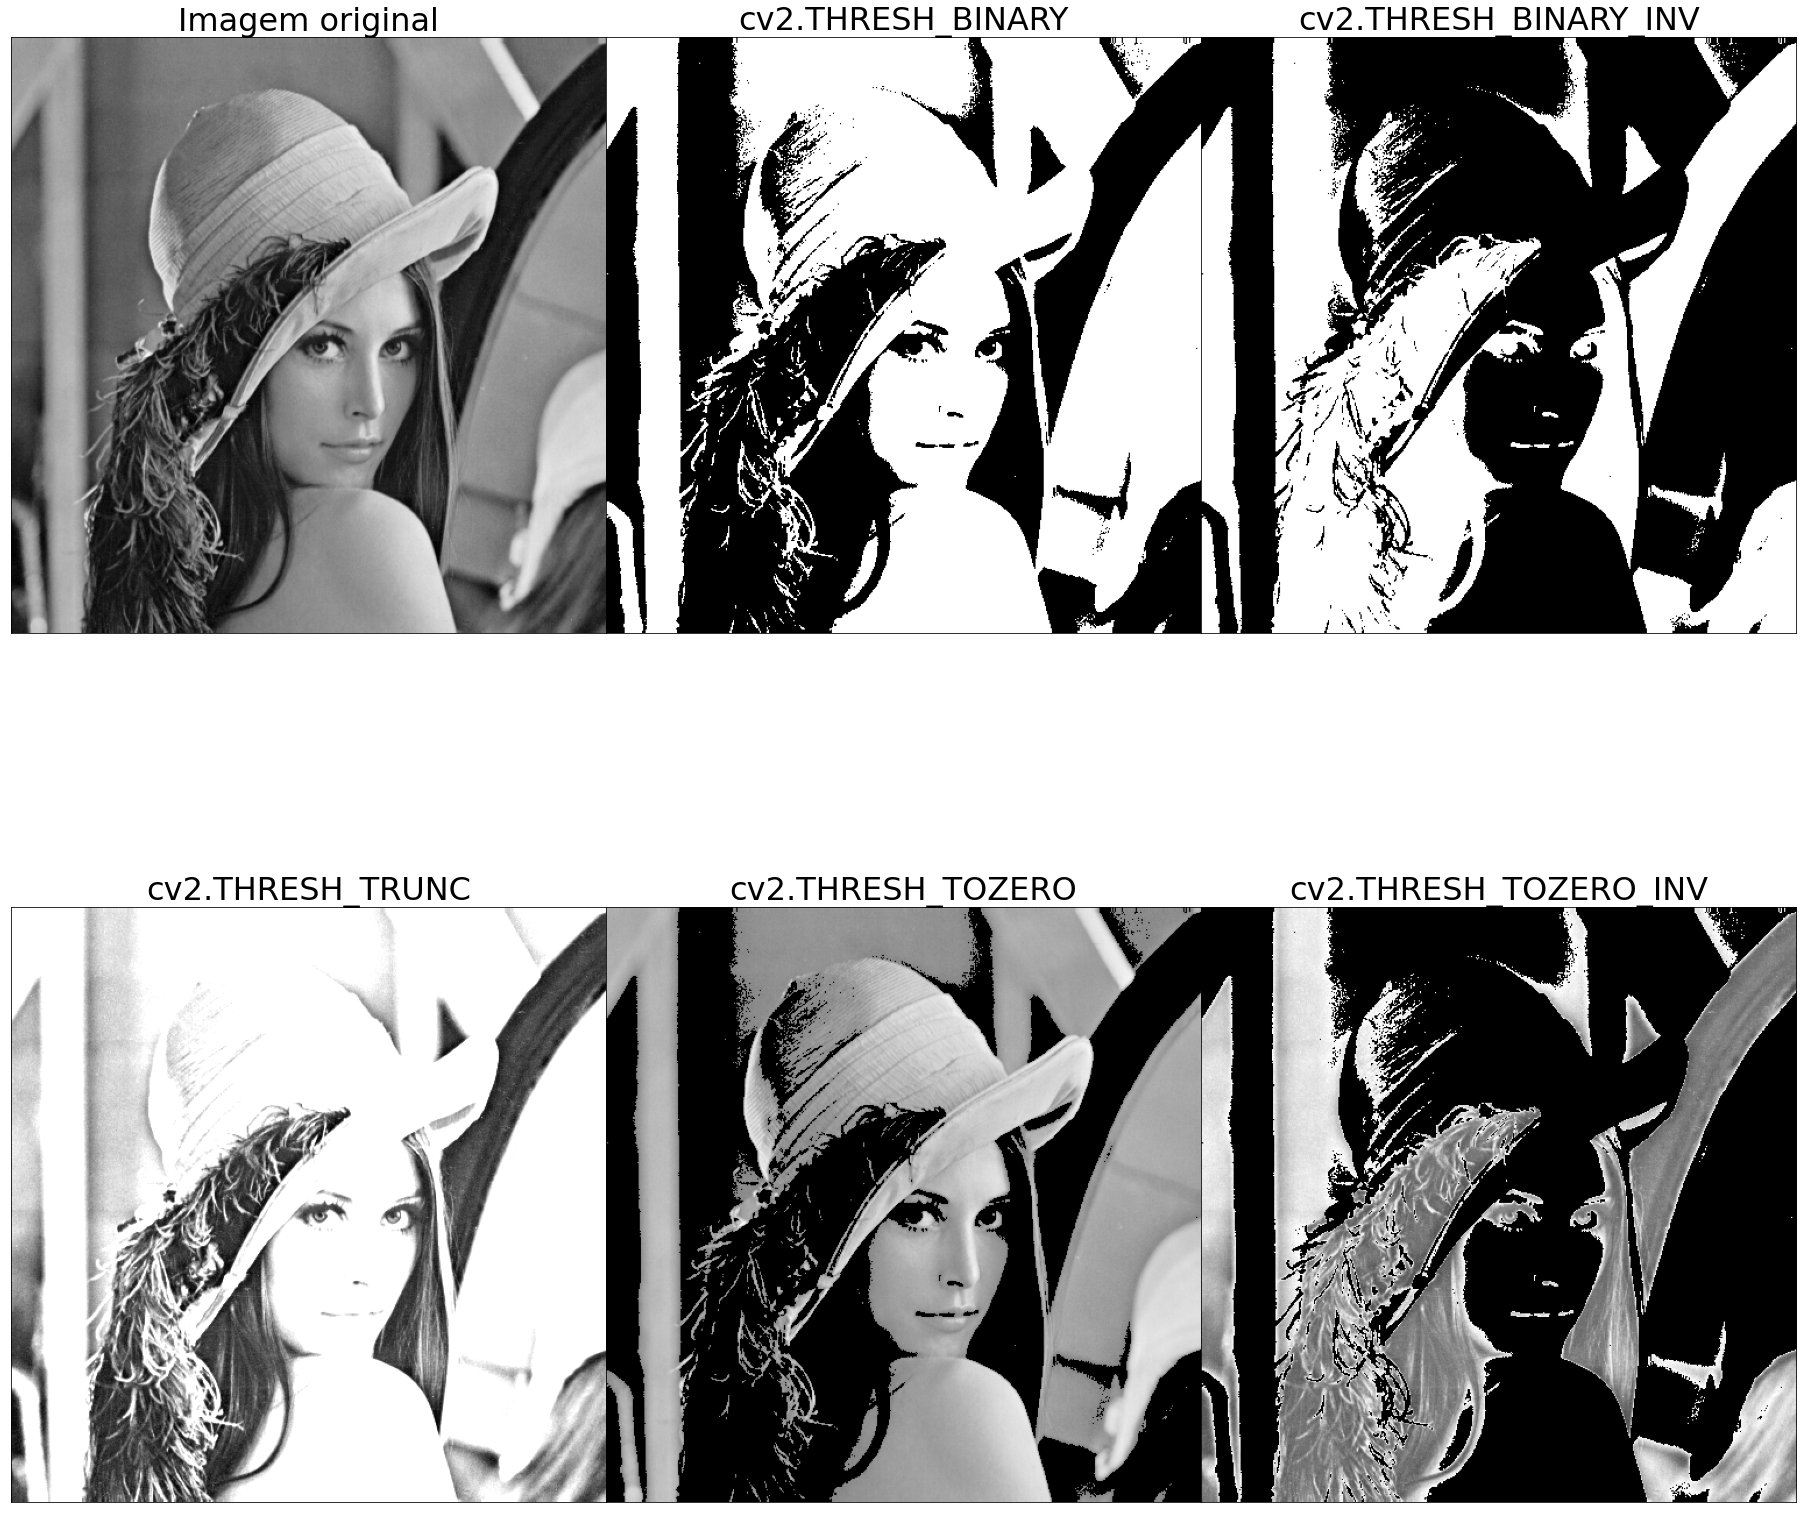

In [12]:
tipo = [None, cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
# As flags, na verdade, são valores inteiros. Pra conseguir mostrar a flag de uma forma sem gambiarras
# vamos criar outra lista
tipo_str = ["cv2.THRESH_BINARY", "cv2.THRESH_BINARY_INV", "cv2.THRESH_TRUNC", "cv2.THRESH_TOZERO", "cv2.THRESH_TOZERO_INV"]

fig, ax = plt.subplots(2, 3, figsize=(32, 32))
fig.subplots_adjust(hspace=0, wspace=0)
cnt = 0

for u in range(2):
    for i in range(3):
            if(tipo[cnt] is not None):
                
                img_limiar = cv2.threshold(img,127,255,tipo[cnt])
                
                ax[u, i].xaxis.set_major_locator(plt.NullLocator())
                ax[u, i].yaxis.set_major_locator(plt.NullLocator())
                ax[u, i].set_title(tipo_str[cnt-1], fontsize=32)                
                ax[u, i].imshow(img_limiar[1], cmap="gray")
                
            else:
                ax[u, i].xaxis.set_major_locator(plt.NullLocator())
                ax[u, i].yaxis.set_major_locator(plt.NullLocator())
                ax[u, i].set_title("Imagem original", fontsize=32)                
                ax[u, i].imshow(img, cmap="gray")
            cnt+=1

### 7.2 Segmentação por cor (usando HSV)

Podemos lembrar que o principal argumento usado a favor do HSV quando falamos de espaços de cores em um momento anterior foi a sua facilidade para segmentação. Como temos apenas um canal pra cor, esse canal acaba tendo informações importantes para encontrar e separar as cores. Vamos trabalhar um exemplo usando uma imagem bem colorida.

Começaremos carregando algumas bibliotecas:

In [21]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

E agora vamos ver a nossa imagem de testes:

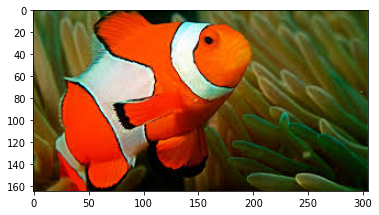

In [22]:
nemo = cv2.imread('nemo.jpeg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)

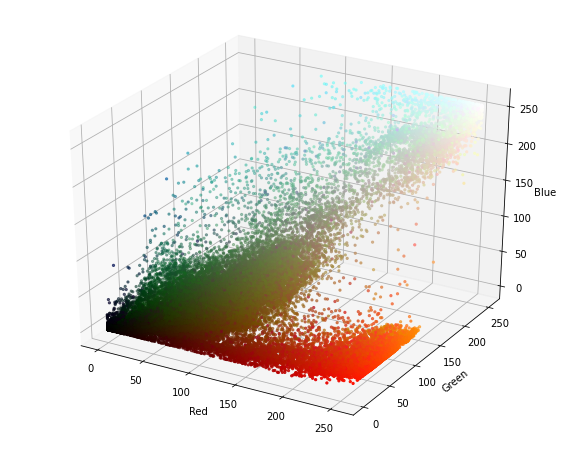

In [50]:
# é preciso aplicar alguns procedimentos na imagem antes de plotar.
pixel_colors = nemo.reshape((nemo.shape[0] * nemo.shape[1], 3)) 
norm = colors.Normalize(vmin=0, vmax=1.)
norm.autoscale(pixel_colors) # seta vmin para minimo do array pixel_colors e vmax para o maximo de pixel_colors
pixel_colors = norm(pixel_colors).tolist()

r, g, b = cv2.split(nemo)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(r.flatten(), g.flatten(), b.flatten(), c=pixel_colors, marker='.')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

Podemos observar pelo plot anterior que as partes laranja da imagem se espalham pelos canais vermelho, verde e azul. Segmentar a imagem do nemo utilizando o sistema RGB não é tão facil nesse caso.



In [48]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

Usando o mesmo processo de plotagem anterior, podemos visualizar a distribuição de pixels no sistema HSV.

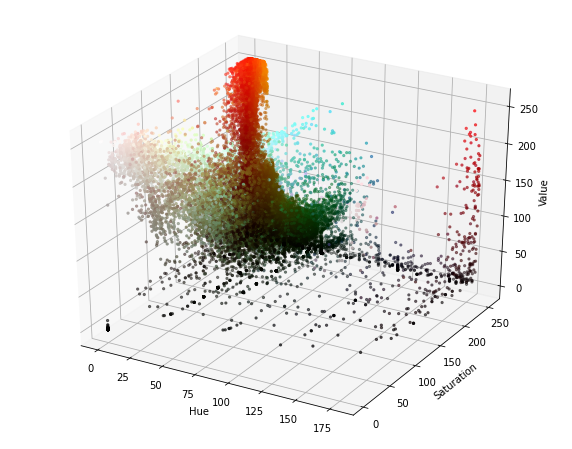

In [52]:
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(h.flatten(), s.flatten(), v.flatten(), c=pixel_colors, marker='.')
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
plt.show()

No espaço HSV, o laranja da imagem está muito mais visualmente localizado e separável. Precisamos escolher uma região entre duas cores para poder limiarizar o nemo. Vamos escolher dois laranjas (um mais claro e outro mais escuro), os quais podem ser visualizá-dos na célula a seguir

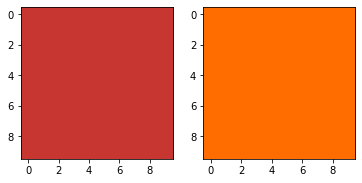

In [55]:
laranja_1 = (1, 190, 200)
laranja_2 = (18, 255, 255) 


l1 = np.full((10, 10, 3), laranja_1, dtype=np.uint8) / 255.0
l2 = np.full((10, 10, 3), laranja_2, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(colors.hsv_to_rgb(l1)) #matplotlib interpreta cores em RGB
plt.subplot(1, 2, 2)
plt.imshow(colors.hsv_to_rgb(l2))
plt.show()

Vamos gerar a limiarização e aplicar uma máscara na imagem:

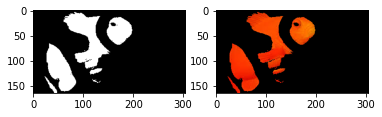

In [66]:
mask_1 = cv2.inRange(hsv_nemo, laranja_1, laranja_2)
result = cv2.bitwise_and(nemo, nemo, mask=mask_1) #onde na máscara for 1 (255) o valor da imagem permanece

plt.subplot(1, 2, 1)
plt.imshow(mask_1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Até aqui, fizemos um excelente trabalho segmentando as cores laranja do nemo. Para obter um nemo mais bonito, vamos realizar os mesmos passos anteriores, porém tentando segmentar as listras brancas do nemo na imagem original. 

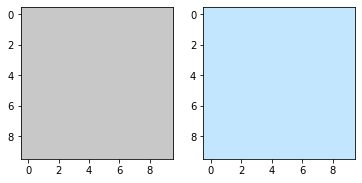

In [60]:
branco_1 = (0, 0, 200)
branco_2 = (145, 60, 255)

b1 = np.full((10, 10, 3), branco_1, dtype=np.uint8) / 255.0
b2 = np.full((10, 10, 3), branco_2, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(colors.hsv_to_rgb(b1))
plt.subplot(1, 2, 2)
plt.imshow(colors.hsv_to_rgb(b2))
plt.show()

Use o método [inRange()](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) para segmentar as listras, a ideia segue a mesma logica aplicada na segmentacao da parte laranja do nemo, porém agora usando os limites de branco mostrados na célula anterior. Após realizar a segmentação, aplique a mascara na imagem original (da mesma forma que antes).

2127536


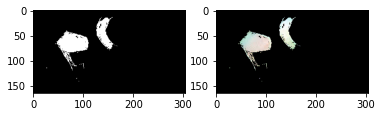

In [70]:
mask_2 = None
listra = None

plt.subplot(1, 2, 1)
plt.imshow(mask_2, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(listra)
plt.show()

In [72]:
# Correção do exercício
if np.sum(listra) == 2127536:
  print('Correto')
else:
  print('Revisar o código da conversão')

Correto


Por último, vamos ver como fica o resultado final da segmentação do nemo por completo.

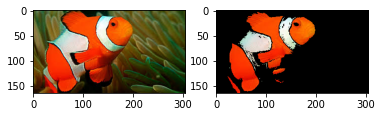

In [68]:
final_mask = mask_1 + mask_2
final_nemo = cv2.bitwise_and(nemo, nemo, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(nemo)
plt.subplot(1, 2, 2)
plt.imshow(final_nemo)
plt.show()

### 7.3 K-Means

O objetivo da quantização é reduzir o número de cores em uma imagem. Usaremos o K-Means para isso. Os 3 canais são 3 características (R, G, B) que serão os nosso dados de entrada. Após a clusterização, nós devolvemos os centróides para uma imagem. É ideal ver a documentação do método [kmeans()](https://docs.opencv.org/3.4/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88) para entender o que está acontecendo. 

In [17]:
from __future__ import print_function
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

img = plt.imread('lenna.jpg')
carac = img.reshape((img.shape[0]*img.shape[1],3))
print(carac.shape)
carac = np.float32(carac)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

def kmeans(K):
    ret,indices,centro=cv2.kmeans(carac,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    centro = np.uint8(centro)
    res = centro[indices.flatten()]
    res2 = res.reshape((img.shape))
    plt.imshow(res2)

(262144, 3)


In [18]:
c = interactive(kmeans, K=(0,20))
display(c)

interactive(children=(IntSlider(value=10, description='K', max=20), Output()), _dom_classes=('widget-interact'…

### 7.4 Connected components labeling

Usaremos o método [connectedComponents()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#connectedcomponents), que nos retorna a conectividade de cada componente. Antes precisamos binarizar a imagem:

In [19]:
img = cv2.imread('lenna.jpg', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1] 

Agora, podemos gerar a imagem a partir dos componentes conectados:

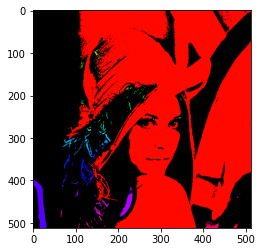

In [20]:
_, indices = cv2.connectedComponents(img)
indices_hue = np.uint8(179*indices/np.max(indices))
canal_vazio = 255*np.ones_like(indices_hue)
img_indices = cv2.merge([indices_hue, canal_vazio, canal_vazio])

img_final = cv2.cvtColor(img_indices, cv2.COLOR_HSV2RGB)
# set bg label to black
img_final[indices_hue==0] = 0

plt.imshow(img_final)